# Gradient descent -- SUGRA potential with 4 parameters (bis)

In this file, we

1) Read potentential from an external file

2) Choose the values for the parameters: 
    - Optimizer: e.g. Adam
    - n_points: Number of randomly initialised points
    - n_steps: Maximum number of steps in gradient descent algorithm
    - spread: size of the hypercube with initial data
    - alpha: initial learning rate
    - n_steps_opt: frequency with which the optimizer is rebooted
    - step_stop_opt: step from which the rebooting is cancelled

3) Perform gradient descent

4) Create /Output/ directory if unavailable and store:
    - Cloud of points and loss function into a .npy files
    - Ancillary file stating the choices above and showing the evolution of the learning process

5) Define visualisation functions


=========================

Changes since Oct 31st:

1) Directory of input file with potential changed
2) Number of variables 'dim' not defined in the notebook, but read from the input file

Changes since Nov 6th:

3) Gradient descent updated with optimiser rebooted every few steps

## Gradient Descent

In [3]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import tensorflow as tf

2024-12-18 11:34:56.788595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 11:34:56.810135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 11:34:56.815420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 11:34:56.831043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 11:34:57.911098: W tensorflow/compiler/tf2

In [4]:
##############################
# Parameters
##############################

potential = "pot_4_param_bis"                          # .py file with potential function V(x) and the number of variables 'dim'

time = np.datetime_as_string(np.datetime64('now'))
time = time.replace('-','_').replace('T','_at_').replace(':','_')

n_points = 10000                                       # Number of randomly initialised points
n_steps = 40000                                          # Maximum number of steps in gradient descent algorithm
spread = 2.2                                            # Initial values for the cloud of points in the hypercube [-spread/2, spread/2]^dim


alpha=10**(-3)              # Initial learning rate
n_steps_opt = 200           # Number of steps before rebooting optimizer
step_stop_opt = 1        


optimizer = tf.keras.optimizers.Adam(learning_rate=alpha)

optimizer_info = optimizer.get_config()

I0000 00:00:1734518098.969748   25559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734518099.025607   25559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734518099.025982   25559 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734518099.027525   25559 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
print(time)

2024_12_18_at_10_34_58


In [6]:
# Saving directory
out_dir = os.getcwd()+'/Output/'

try:
    os.mkdir(out_dir)
    print(f"Directory '{out_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{out_dir}' already exists.")
except PermissionError:
    print(f"Permission denied: Unable to create '{out_dir}'.")
except Exception as e:
    print(f"An error occurred: {e}")


# Output File names
attempt = f"_{potential}_{n_points}_{time}"

info_file = out_dir + 'Comments' + attempt + '.txt'
data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'


f_info = open(info_file, 'w')


f_info.write(f'File created on {time}')
f_info.write(f'\n\nPotential : {potential}')
f_info.write(f'\nNumber of points: {n_points}')
f_info.write(f'\nNumber of steps: {n_steps}\n')
f_info.write(f'\nn_steps_opt: {n_steps_opt}\n')
f_info.write(f'\nstep_stop_opt: {step_stop_opt}\n')
f_info.write('\nOptimizer:\n')


for key, value in optimizer_info.items(): 
    f_info.write('  - %s : %s\n' % (key, value))

f_info.write('\nEvolution:')
f_info.flush()

Directory '/home/camille/Documents/Science/MLFlatDirections/Output/' already exists.


In [7]:
# Loading the potential
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim

print(dim)
help(V)

4
Help on function V in module pot_4_param_bis:

V(x)
    0.5 * (tf.exp(-2 * x8)) * (1 + 2 * (tf.exp(x8)) * (-2 + x2 ** 2 -4 * (x4 ** 2)) + (tf.exp(2 * x8)) * (2 -4 * (x2 ** 2) + x2 ** 4 + 16 * (x4 ** 2) + 16 * (x4 ** 4) -8 * (x6 ** 2)) -2 * (tf.exp(3 * x8)) * (2 + x2 ** 4 -((x2 ** 2) * (1 + 4 * (x4 ** 2))) + (x4 ** 2) * (4 -16 * (x6 ** 2))) + (tf.exp(4 * x8)) * (x2 ** 4 + 8 * (x2 ** 2) * (x6 ** 2) + (1 + 4 * (x6 ** 2)) ** 2))



In [8]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [9]:
# Randomly initialize the points
x = tf.Variable(spread*np.random.rand(n_points, dim)-(spread/2), dtype=tf.float32)


loss_history = []


# Learning loop 
for step in range(n_steps):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
        loss_history.append(loss)
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x])
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x]))
    
    # Update the information in info file
    if step % 500 == 0:
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        f_info.flush()
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        f_info.write("\n\nConverged enough") 
        f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

f_info.close()

# Saving loss and final cloud of points
np.save(data_file,x)
np.save(loss_file,loss_history)

In [15]:
# # Randomly initialize the points
# x = tf.Variable(np.random.rand(n_points, 3)+1, dtype=tf.float32)


# loss_history = []

# update_opt = False


# # Learning loop 
# for step in range(n_steps):  
#     with tf.GradientTape() as tape:
#         loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
#         loss_history.append(loss)
    
#     # Compute ||∇V||^2 with respect to x
#     gradients = tape.gradient(loss, [x])
        
#     # Apply gradient descent for all points
#     optimizer.apply_gradients(zip(gradients, [x]))
    
#     # Updates of optimizer
#     if update_opt and step % n_steps_opt ==0 :
#         print("Reinitializing the optimizer")
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)

#     if step == step_stop_opt:
#         update_opt = False
    
#     if (step - step_stop_opt)%(3*n_steps_opt) == 0:
#         alpha = alpha/10
#         optimizer = tf.optimizers.Adam(learning_rate=alpha)


#     # Update the information in info file
#     if step % 500 == 0:
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         f_info.flush()
        
#     if np.log(loss.numpy())/np.log(10)<-8: 
#         f_info.write("\n\nConverged enough") 
#         f_info.write(f"\n  Step {step}: ||∇V||^2 = {loss.numpy()}")
#         break

# f_info.close()

# # Saving loss and final cloud of points
# np.save(data_file,x)
# np.save(loss_file,loss_history)

## Results

In [2]:
import os
from importlib.machinery import SourceFileLoader

import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

import tensorflow as tf

### Functions

In [3]:
# compute (||∇V||^2)
def grad_norm_squared(V, x):
    
    # Record operations for automatic differentiation:
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)                                     # compute V at each point
    gradients = tape.gradient(loss, x)                  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

In [4]:
def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
    plt.show()

def triangular_plot_axes_lim(chains,mask):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i+1} counts")

    for i in range(ndim):
        for j in range(i):
            ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
            counts,xbins,ybins,image = ax.hist2d(data[mask,j],data[mask,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
            plt.colorbar(image)
            ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
            ax.set_xlabel(f'x{j+1}')
            ax.set_ylabel(f'x{i+1}')
            ax.set_xlim([np.min(data[:,j]), np.max(data[:,j])])
            ax.set_ylim([np.min(data[:,i]), np.max(data[:,i])])
    plt.show()
    
# def triangular_plot(chains,figname):
#     data=chains
#     nsteps,ndim=chains.shape
#     fig = plt.figure(figsize=(20,20))
#     for i in range(ndim):
#         ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        
#         ax.hist(data[:,i], 100, color="k", histtype="step")
#         ax.set_title(f"x{i+1} counts")

#     for i in range(ndim):
#         for j in range(i):
#             ax = fig.add_subplot(ndim,ndim,i*ndim+j+1)
#             counts,xbins,ybins,image = ax.hist2d(data[:,j],data[:,i],bins=100, norm=LogNorm(), cmap = plt.cm.rainbow)
#             plt.colorbar(image)
#             ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
#             ax.set_xlabel(f'x{j+1}')
#             ax.set_ylabel(f'x{i+1}')
#     plt.savefig(figname)
#     plt.show()


def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
    plt.show()

### Analysis

In [13]:
# Loading the potential
potential = "pot_4_param_bis"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_18_at_10_34_58'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'

In [14]:

x = tf.Variable(np.load(data_file), dtype=tf.float32)
loss_history = np.load(loss_file)

In [15]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(grad_norm_squared(V,x).numpy()>10**(-i))}")

Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 21
Number of points with ||∇V||^2 > 1e-06 : 188
Number of points with ||∇V||^2 > 1e-07 : 499
Number of points with ||∇V||^2 > 1e-08 : 1135
Number of points with ||∇V||^2 > 1e-09 : 2101
Number of points with ||∇V||^2 > 1e-10 : 3389
Number of points with ||∇V||^2 > 1e-11 : 4647
Number of points with ||∇V||^2 > 1e-12 : 6266
Number of points with ||∇V||^2 > 1e-13 : 7024
Number of points with ||∇V||^2 > 1e-14 : 7249


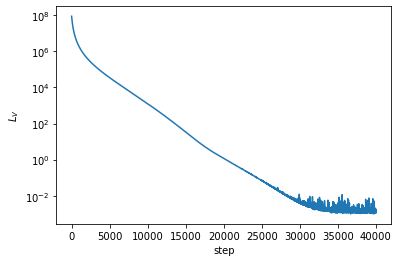

In [16]:
plt.figure(1)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('$L_{V}$')
plt.show()

<Figure size 432x288 with 0 Axes>

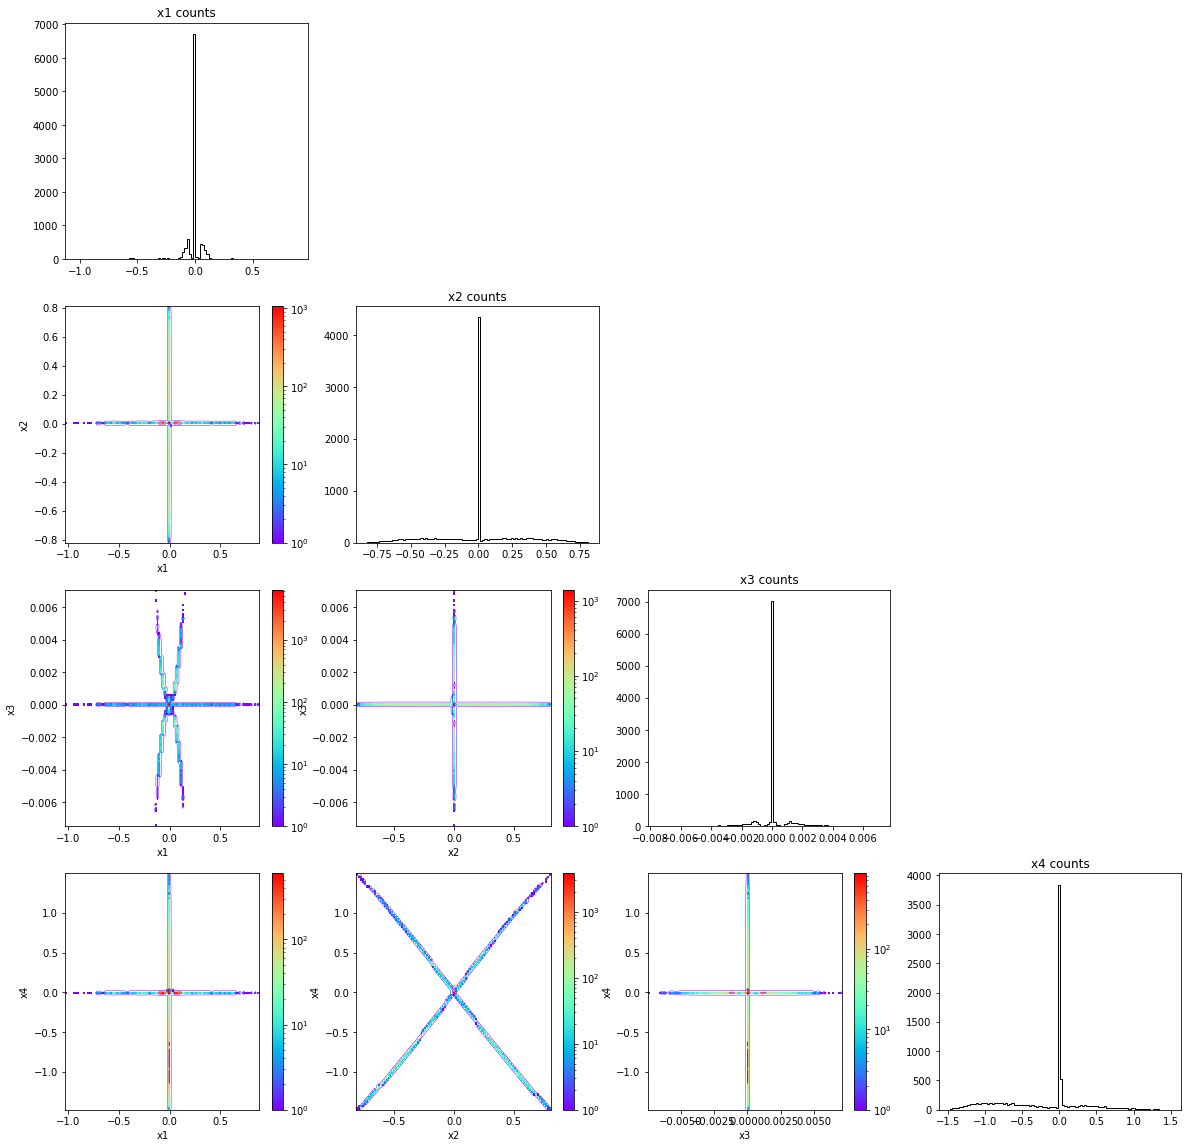

In [17]:
plt.figure(1)
triangular_plot(x.numpy())

# Autoencoder

In [5]:
import os
from importlib.machinery import SourceFileLoader


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model

In [6]:
# Loading the potential
potential = "pot_4_param_bis"                         # .py file with potential function V(x)
module = SourceFileLoader(potential,os.getcwd()+'/Potential_generator/'+potential+'.py').load_module()
V = module.V
dim = module.dim


out_dir = os.getcwd()+'/Output/'
time = '2024_12_18_at_10_34_58'
n_points = 10000

attempt = f"_{potential}_{n_points}_{time}"

data_file = out_dir + 'Points' + attempt + '.npy'
loss_file = out_dir + 'Loss' + attempt + '.npy'
AE_loss_file = out_dir + 'AE_all_loss' + attempt + '.npy'
AE_val_loss_file = out_dir + 'AE_all_val_loss' + attempt + '.npy'

In [7]:
x = np.load(data_file)
loss_history = np.load(loss_file)

In [8]:
x_train, x_test = train_test_split(x, test_size=0.15, random_state=42)

In [9]:
print(f'shape of total set of points: {x.shape}')
print(f'shape of training set of points: {x_train.shape}')
print(f'shape of validation set of points: {x_test.shape}')

shape of total set of points: (10000, 4)
shape of training set of points: (8500, 4)
shape of validation set of points: (1500, 4)


## Determining the dimension of the conformal manifold

### Latent dimension = 1

In [23]:
input_dim = dim  
latent_dim = 1  

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [24]:
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,669 (6.52 KB)

 Trainable params: 1,669 (6.52 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 10000
history_AE_1 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000


I0000 00:00:1734521308.558178   25621 service.cc:146] XLA service 0x7d3a9800e070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734521308.558198   25621 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-18 12:28:28.610264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 12:28:28.856840: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


59/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0467

I0000 00:00:1734521310.551823   25621 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.0191 - val_loss: 0.7798
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7231 - val_loss: 0.5616
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5233 - val_loss: 0.4133
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3856 - val_loss: 0.3114
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2940 - val_loss: 0.2407
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2273 - val_loss: 0.1919
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1818 - val_loss: 0.1586
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1519 - val_loss: 0.1365
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1313 - val_loss: 0.1222
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1186 - val_loss: 0.1133
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1103 - val_loss: 0.1081
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [32]:
autoencoder_1 = autoencoder
encoder_1 = models.Model(inputs,encoded)
decoder_1 = models.Model(encoded,decoded)

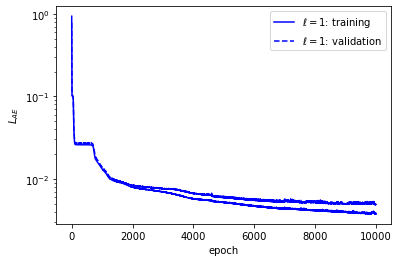

In [35]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

### Latent dimension = 2

In [27]:
input_dim = dim  
latent_dim = 2

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [28]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686 (6.59 KB)

 Trainable params: 1,686 (6.59 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs = 10000
history_AE_2 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.7783 - val_loss: 0.6010
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5522 - val_loss: 0.4290
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3938 - val_loss: 0.3086
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2822 - val_loss: 0.2269
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2104 - val_loss: 0.1734
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1627 - val_loss: 0.1405
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1328 - val_loss: 0.1214
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1167 - val_loss: 0.1111
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1094 - val_loss: 0.1059
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1050 - val_loss: 0.1037
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1017 - val_loss: 0.1026
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

In [30]:
autoencoder_2 = autoencoder
encoder_2 = models.Model(inputs,encoded)
decoder_2 = models.Model(encoded,decoded)

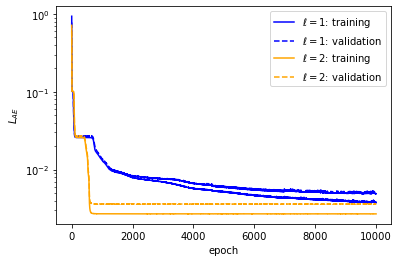

In [31]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

### Latent dimension = 3

In [32]:
input_dim = dim  
latent_dim = 3

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [33]:
autoencoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703 (6.65 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
epochs = 10000
history_AE_3 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.9187 - val_loss: 2.4781
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3338 - val_loss: 2.0045
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9031 - val_loss: 1.6246
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5362 - val_loss: 1.3173
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2488 - val_loss: 1.0666
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0044 - val_loss: 0.8620
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8176 - val_loss: 0.6954
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6633 - val_loss: 0.5605
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5265 - val_loss: 0.4519
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4200 - val_loss: 0.3656
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3473 - val_loss: 0.2977
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 1695/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 1696/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 1697/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1698/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1699/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1700/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 1701/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 1702/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 1703/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 1704/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 1705/10000
85/85 ━━━━

In [40]:
autoencoder_3 = autoencoder
encoder_3 = models.Model(inputs,encoded)
decoder_3 = models.Model(encoded,decoded)

In [37]:
AE_file = out_dir + 'AE_l3' + attempt + '.keras'

# Utiliser plutot .keras?

In [38]:
AE_file

'/home/camille/Documents/Science/MLFlatDirections/Output/AE_l3_pot_4_param_bis_10000_2024_12_18_at_10_34_58.keras'

In [ ]:
# autoencoder_3.save(AE_file)

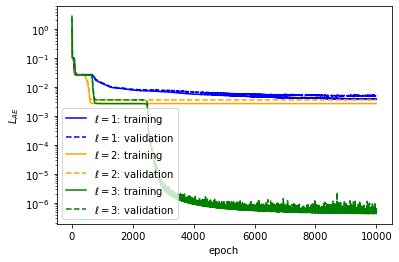

In [42]:
plt.plot(history_AE_1.history['loss'], label='$\ell=1$: training',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='$\ell=2$: training',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

### Latent dimension = 4

In [43]:
input_dim = dim  
latent_dim = 4

# Encoder
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(32, activation='sigmoid')(inputs)
encoded = layers.Dense(16, activation='sigmoid')(encoded)
encoded = layers.Dense(8, activation='sigmoid')(encoded)
encoded = layers.Dense(latent_dim)(encoded)  

# Decoder
decoded = layers.Dense(8, activation='sigmoid')(encoded)
decoded = layers.Dense(16, activation='sigmoid')(decoded)
decoded = layers.Dense(32, activation='sigmoid')(decoded)
decoded = layers.Dense(input_dim)(decoded)  

# Autoencoder 
autoencoder = models.Model(inputs, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss='mse')

In [44]:
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,720 (6.72 KB)

 Trainable params: 1,720 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
epochs = 10000
history_AE_4 = autoencoder.fit(x_train, x_train, epochs=epochs, batch_size=100, shuffle=True,validation_data=(x_test, x_test))

Epoch 1/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4783 - val_loss: 0.3328
Epoch 2/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3017 - val_loss: 0.2140
Epoch 3/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1977 - val_loss: 0.1512
Epoch 4/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 - val_loss: 0.1212
Epoch 5/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1178 - val_loss: 0.1087
Epoch 6/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1039 - val_loss: 0.1040
Epoch 7/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1024 - val_loss: 0.1026
Epoch 8/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1010 - val_loss: 0.1022
Epoch 9/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - val_loss: 0.1021
Epoch 10/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 - val_loss: 0.1021
Epoch 11/10000
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0996 - val_loss: 0.1021
Epoch 12/10000
85/85 ━━━━━━━━━━━━━━━━━━━━

In [50]:
autoencoder_4 = autoencoder
encoder_4 = models.Model(inputs,encoded)
decoder_4 = models.Model(encoded,decoded)

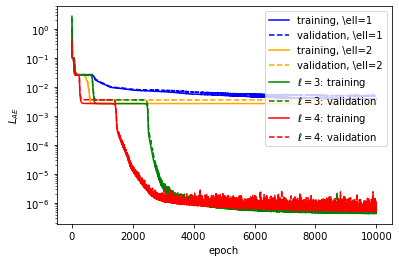

In [49]:
plt.plot(history_AE_1.history['loss'], label='training, \ell=1',color='blue')
plt.plot(history_AE_1.history['val_loss'], label='validation, \ell=1',color='blue',linestyle='--')
plt.plot(history_AE_2.history['loss'], label='training, \ell=2',color='orange')
plt.plot(history_AE_2.history['val_loss'], label='validation, \ell=2',color='orange',linestyle='--')
plt.plot(history_AE_3.history['loss'], label='$\ell=3$: training',color='green')
plt.plot(history_AE_3.history['val_loss'], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(history_AE_4.history['loss'], label='$\ell=4$: training',color='red')
plt.plot(history_AE_4.history['val_loss'], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend()

plt.show()

# plt.savefig('../LaTeX/Notes/Figures/lossAE_higgs.png')

In [51]:
loss_history_all = np.array([history_AE_1.history['loss'],history_AE_2.history['loss'],history_AE_3.history['loss'],history_AE_4.history['loss']])
val_loss_history_all = np.array([history_AE_1.history['val_loss'],history_AE_2.history['val_loss'],history_AE_3.history['val_loss'],history_AE_4.history['val_loss']])

np.save(AE_loss_file,loss_history_all)
np.save(AE_val_loss_file,val_loss_history_all)

## Results and analysis of l = 3

### Loss functions

In [10]:
loss_history_all = np.load(AE_loss_file)
val_loss_history_all = np.load(AE_val_loss_file)

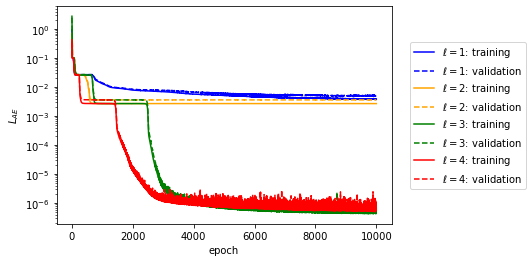

In [11]:
plt.plot(loss_history_all[0], label='$\ell=1$: training',color='blue')
plt.plot(val_loss_history_all[0], label='$\ell=1$: validation',color='blue',linestyle='--')
plt.plot(loss_history_all[1], label='$\ell=2$: training',color='orange')
plt.plot(val_loss_history_all[1], label='$\ell=2$: validation',color='orange',linestyle='--')
plt.plot(loss_history_all[2], label='$\ell=3$: training',color='green')
plt.plot(val_loss_history_all[2], label='$\ell=3$: validation',color='green',linestyle='--')
plt.plot(loss_history_all[3], label='$\ell=4$: training',color='red')
plt.plot(val_loss_history_all[3], label='$\ell=4$: validation',color='red',linestyle='--')

plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('$L_{AE}$')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

plt.show()

### Analysis of the l = 3 autoencoder

In [12]:
AE_file = out_dir + 'AE_l3' + attempt + '.keras'

autoencoder_3 = models.load_model(AE_file)
autoencoder_3.summary()

I0000 00:00:1734604199.991235   24444 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734604200.100147   24444 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734604200.100800   24444 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1734604200.102674   24444 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,111 (19.97 KB)

 Trainable params: 1,703 (6.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,408 (13.32 KB)

In [13]:
# Encoder
inputs = layers.Input(shape=(dim,))
encoded = autoencoder_3.layers[1](inputs)
encoded = autoencoder_3.layers[2](encoded)
encoded = autoencoder_3.layers[3](encoded)
encoded = autoencoder_3.layers[4](encoded)

encoder_3 = Model(inputs=inputs, outputs=encoded)

encoder_3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851 (3.32 KB)

 Trainable params: 851 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Decoder
decoded = autoencoder_3.layers[5](encoded)
decoded = autoencoder_3.layers[6](decoded)
decoded = autoencoder_3.layers[7](decoded)
decoded = autoencoder_3.layers[8](decoded)

decoder_3 = Model(inputs=encoded, outputs=decoded)

decoder_3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_20CLONE            │ (None, 3)              │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 852 (3.33 KB)

 Trainable params: 852 (3.33 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# test autoencoder
encoded_points = encoder_3.predict(x)

I0000 00:00:1734604213.029007   34165 service.cc:146] XLA service 0x7a06080064c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734604213.029035   34165 service.cc:154]   StreamExecutor device (0): Quadro T2000 with Max-Q Design, Compute Capability 7.5
2024-12-19 11:30:13.040046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 11:30:13.091829: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


111/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1734604213.409598   34165 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


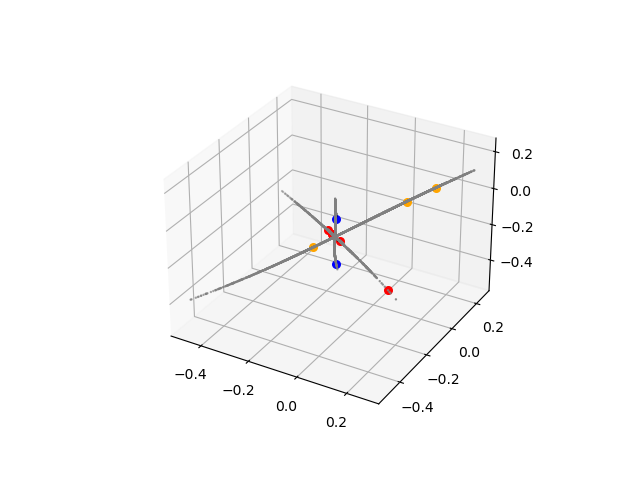

In [170]:
%matplotlib widget

# test=np.random.randint(0,len(encoded_points))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(encoded_points[:,0], encoded_points[:,1], encoded_points[:,2],s=0.5,color='gray')
ax.scatter(encoded_points[6252,0], encoded_points[6252,1], encoded_points[6252,2],s=30,color='red')
ax.scatter(encoded_points[4684,0], encoded_points[4684,1], encoded_points[4684,2],s=30,color='red')
ax.scatter(encoded_points[1731,0], encoded_points[1731,1], encoded_points[1731,2],s=30,color='red')
ax.scatter(encoded_points[1373,0], encoded_points[1373,1], encoded_points[1373,2],s=30,color='red')
ax.scatter(encoded_points[6517,0], encoded_points[6517,1], encoded_points[6517,2],s=30,color='red')
# ax.scatter(encoded_points[6775,0], encoded_points[6775,1], encoded_points[6775,2],s=30,color='blue')
ax.scatter(encoded_points[5903,0], encoded_points[5903,1], encoded_points[5903,2],s=30,color='blue')
ax.scatter(encoded_points[4340,0], encoded_points[4340,1], encoded_points[4340,2],s=30,color='blue')
ax.scatter(encoded_points[6253,0], encoded_points[6253,1], encoded_points[6253,2],s=30,color='orange')
ax.scatter(encoded_points[8036,0], encoded_points[8036,1], encoded_points[8036,2],s=30,color='orange')
ax.scatter(encoded_points[4402,0], encoded_points[4402,1], encoded_points[4402,2],s=30,color='orange')
# ax.scatter(encoded_points[test,0], encoded_points[test,1], encoded_points[test,2],s=15,color='green')

We see three intersecting lines.

Find the points belonging to one line (orange)

In [86]:
# Points in a given plane (see 3d plot)
A=encoded_points[8036]
B=encoded_points[4402]

# vectors in the plane
v1 = (A-B)
v1 /= np.linalg.norm(v1)

# # generate a vector normal to v1
# v1n1 = np.random.randn(3)  # take a random vector
# v1n1 -= np.dot(v1,v1n1) * v1       # make it orthogonal to v1
# v1n1 /= np.linalg.norm(v1n1)  # normalize it

# # generate a vector normal to v1 and v1n1
# v1n2 = np.cross(v1,v1n1)
# v1n2 /= np.linalg.norm(v1n2)

# Define projector on the line
P1 = np.eye(3) - np.outer(v1,v1)

In [88]:
np.linalg.norm(np.dot(P1,v1))

8.866939736689474e-08

In [136]:
mask1 = np.linalg.norm(np.dot(P1,(encoded_points-A).T),axis=0)<5e-3

np.sum(mask1)

3640

Second line (red)

In [ ]:
# Points in a given plane (see 3d plot)
A=encoded_points[6252]
B=encoded_points[6517]

# vectors in the plane
v2 = (A-B)
v2 /= np.linalg.norm(v2)

# Define projector on the line
P2 = np.eye(3) - np.outer(v2,v2)

In [143]:
mask2 = np.linalg.norm(np.dot(P2,(encoded_points-A).T),axis=0)<1e-2

np.sum(mask2)

4224

Third line (blue)

In [171]:
# Points in a given plane (see 3d plot)
A=encoded_points[5903]
B=encoded_points[4340]

# vectors in the plane
v3 = (A-B)
v3 /= np.linalg.norm(v3)

# Define projector on the line
P3 = np.eye(3) - np.outer(v3,v3)

In [181]:
mask3 = np.linalg.norm(np.dot(P3,(encoded_points-A).T),axis=0)<8e-3

np.sum(mask3)

3604

In [173]:
np.sum(np.logical_or(mask1,mask2,mask3))

6791

We loose some points, but not too bad.

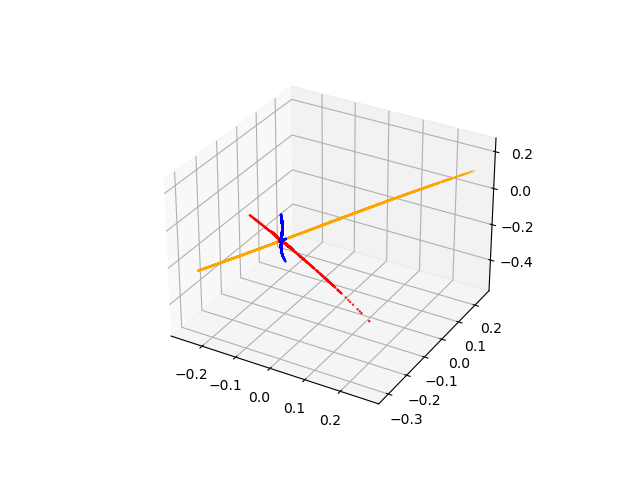

In [182]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(encoded_points[np.logical_not(mask1),0], encoded_points[np.logical_not(mask1),1], encoded_points[np.logical_not(mask1),2],s=0.5)
ax.scatter(encoded_points[mask1,0], encoded_points[mask1,1], encoded_points[mask1,2],s=0.5,color='orange')
ax.scatter(encoded_points[mask2,0], encoded_points[mask2,1], encoded_points[mask2,2],s=0.5,color='red')
ax.scatter(encoded_points[mask3,0], encoded_points[mask3,1], encoded_points[mask3,2],s=0.5,color='blue')

In [183]:
%matplotlib inline

In [184]:
plt.figure(1)
triangular_plot_axes_lim(x,mask1)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

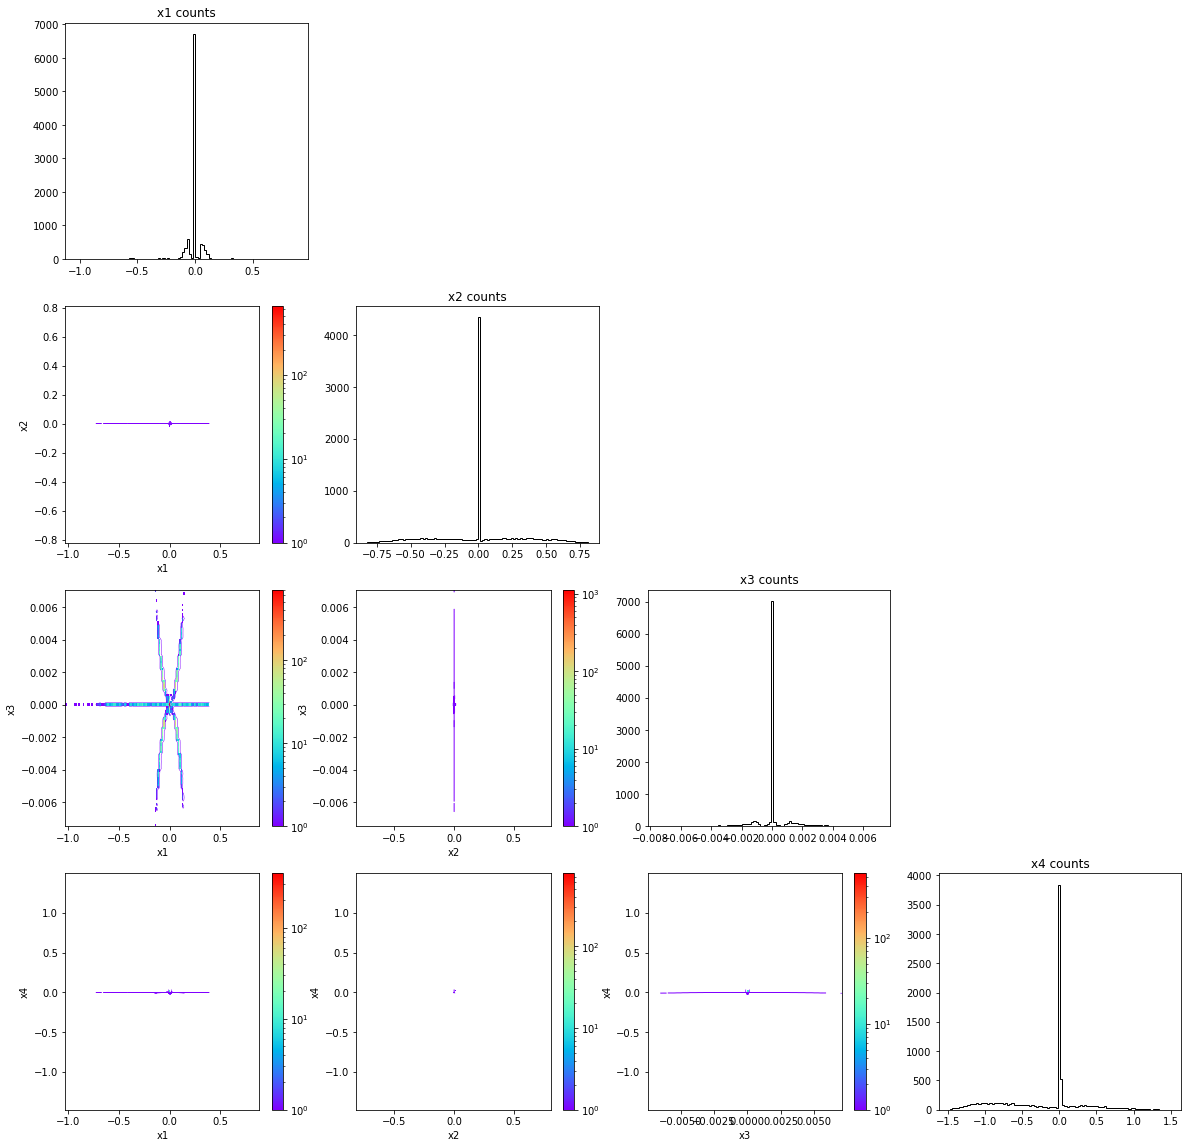

In [168]:
plt.figure(1)
triangular_plot_axes_lim(x,mask2)

<Figure size 432x288 with 0 Axes>

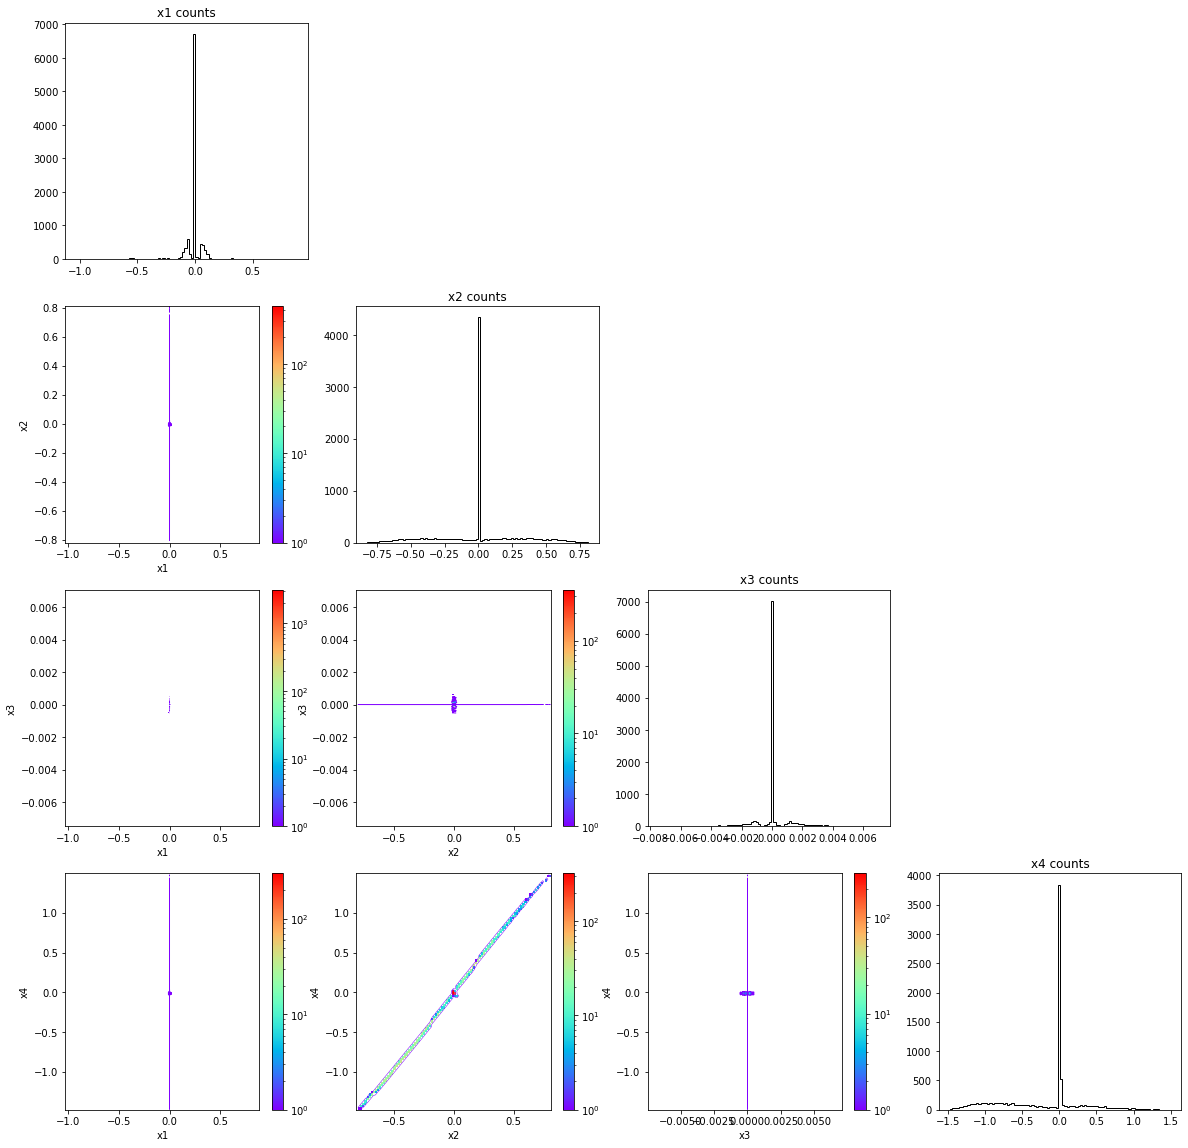

In [185]:
plt.figure(1)
triangular_plot_axes_lim(x,mask3)

### Learning the first plane